# Trustworthy Artificial Intelligence - 20.12.2022 Exam

This exam is composed of 3 different exercises, for a total score of **18 points**.


In [1]:
try:
 import secml
except ImportError:
 %pip install git+https://github.com/pralab/secml
 %pip install foolbox

In [2]:
from secml.data.splitter import CTrainTestSplit
from secml.data.loader import CDLRandomBlobs

random_state = 444

n_features = 2 # number of features
centers = [[2, -2], [2, 2], [-2,0]] # centers of the clusters
cluster_std = 0.6 # standard deviation of the clusters
n_classes = len(centers) # number of classes

n_tr = 1000 # Number of training set samples
n_ts = 100 # Number of test set samples

n_samples = n_ts + n_tr # number of samples

dataset = CDLRandomBlobs(n_features=n_features,
 centers=centers,
 cluster_std=cluster_std,
 n_samples=n_samples,
 random_state=random_state).load()

splitter = CTrainTestSplit(
 train_size=n_tr, test_size=n_ts, random_state=random_state)
tr, ts = splitter.split(dataset)

# Normalize the data
from secml.ml.features import CNormalizerMinMax

nmz = CNormalizerMinMax()
tr.X = nmz.fit(dataset.X).transform(tr.X)
ts.X = nmz.transform(ts.X)

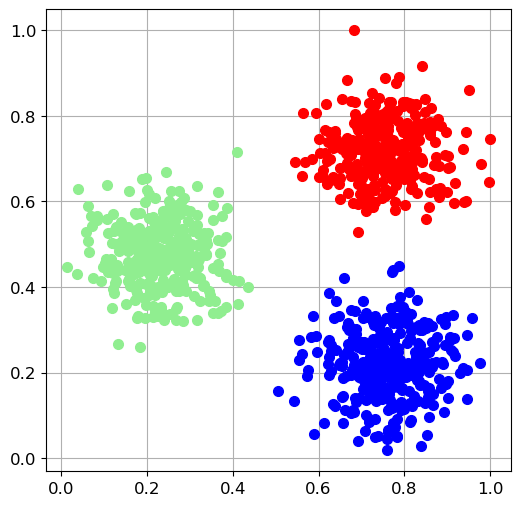

In [4]:
from secml.figure import CFigure
import matplotlib
%matplotlib inline

fig = CFigure()
fig.sp.plot_ds(tr)
fig.show()
fig.savefig('tr_plot.png')

from PIL import Image
img = Image.open('tr_plot.png')
img.show()

# Exercise 1 (6 Points)

Complete the following tasks using SecML:
* Fit a SVM using the ad-hoc SecML class on the provided training set, with default hyper-parameters
* Compute the accuracy on the test set using the CMetricAccuracy object
* Plot the learned decision function using the ad-hoc method of the CFigure class

Fit the SVM

In [6]:
from secml.ml.classifiers import CClassifierSVM
from secml.ml.kernels import CKernelRBF

# Create a SVM classifier with RBF kernel
clf = CClassifierSVM(kernel=CKernelRBF())

# Fit the classifier on the training set
clf.fit(tr.X, tr.Y)

CClassifierSVM{'classes': CArray(3,)(dense: [0 1 2]), 'n_features': 2, 'preprocess': CKernelRBF{'gamma': 1.0, 'rv': CArray(112, 2)(dense: [[0.436457 0.399387] [0.562343 0.243402] [0.364626 0.452888] ... [0.788943 0.353143] [0.916113 0.596797] [0.707211 0.605696]]), 'preprocess': None, 'n_jobs': 1}, 'n_jobs': 1, 'C': 1.0, 'class_weight': None, 'w': None, 'b': CArray(3,)(dense: [-1.503482 -1.453063 -0.857298]), 'alpha': CArray(3, 112)(sparse: (0, 0) -1.0  (0, 1) 1.0  (0, 3) -1.0  (0, 5) -1.0  (0, 7) -1.0  (0, 9) -1.0  (0, 10) -1.0  (0, 12) 1.0  (0, 15) 1.0  (0, 17) 1.0  (0, 18) -1.0  (0, 19) 1.0  (0, 20) -1.0  (0, 21) 1.0  (0, 22) 1.0  (0, 25) -1.0  (0, 27) 1.0  (0, 28) 1.0  (0, 29) -0.7587228964930101  (0, 30) -1.0  (0, 31) 1.0  (0, 34) -1.0  (0, 35) -1.0  (0, 36) 1.0  (0, 37) -1.0  : :  (2, 44) -1.0  (2, 47) 1.0  (2, 54) -1.0  (2, 58) 1.0  (2, 59) 1.0  (2, 61) -0.3845779828651597  (2, 68) -1.0  (2, 70) -1.0  (2, 72) 1.0  (2, 74) -1.0  (2, 75) -1.0  (2, 76) -1.0  (2, 77) -1.0  (2, 80) 1

Compute Accuracy

In [7]:
from secml.ml.peval.metrics import CMetricAccuracy

# Create a metric object to compute accuracy
metric = CMetricAccuracy()

# Compute and print accuracy on the test set
acc = metric.performance_score(y_true=ts.Y, y_pred=clf.predict(ts.X))
print(f"Accuracy on test set: {acc:.2f}")

Accuracy on test set: 1.00


Display Decision Function

In [8]:
from secml.figure import CFigure
import matplotlib
%matplotlib inline

fig = CFigure()
fig.sp.plot_ds(ts)
fig.sp.plot_decision_regions(clf, plot_background=True, n_grid_points=100)
#fig.show()
fig.savefig('LDfunction_tr.png')

from PIL import Image
img = Image.open('LDfunction_tr.png')
img.show()

# Exercise 2 (10 Points)

Compute a security evaluation curve of the trained model using SecML, with the following setup:
* use the CFoolboxPGDLInf attack from the SecML library, with 20 iterations and 0.05 as absolute step size, no random start, lower bound 0 and upper bound 1
* use at least 8 values for the perturbation budget $\epsilon$. Which maximum value should you pick, starting from zero?
* plot the security evaluation curve using the ad-hoc method of the CFigure class

Setting Up the Attack

In [9]:
from secml.adv.attacks.evasion import CFoolboxPGDLinf
from secml.array import CArray

# Define the attack
attack = CFoolboxPGDLinf(
    classifier=clf, 
    y_target=None, 
    lb=0, 
    ub=1, 
    abs_stepsize=0.05, 
    steps=20, 
    random_start=False
)

# Define epsilon values for perturbation budget
epsilons = CArray.linspace(start=0, stop=1, num=8) # to create 8 values between 0 and 1 with the same distance
#epsilons = CArray([0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]) # if I have to choose it

Computing Security Evaluation Curve

In [10]:
from secml.adv.seceval import CSecEval

# Create the security evaluation object
seval = CSecEval(attack, param_name='epsilon', param_values=epsilons)

# Run the security evaluation on the test set
seval.run_sec_eval(ts)

Displaying Security Evaluation Curve

In [11]:
from secml.figure import CFigure
import matplotlib
%matplotlib inline

fig = CFigure()
fig.sp.plot_sec_eval(seval.sec_eval_data, marker='o')
#fig.show()
fig.savefig('SEcurve.png')

from PIL import Image
img = Image.open('SEcurve.png')
img.show()

2023-12-17 12:01:30,887 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


# Exercise 3 (2 Points)

Find and fix the bug of the proposed implementation of PGD L2, and execute it against the trained classifer.

In [12]:
from secml.array import CArray
from secml.ml import CClassifier
from secml.ml.classifiers.loss import CLossCrossEntropy

def pgd_l2_targeted(clf : CClassifier, x : CArray, y_original : CArray, y_target : int, steps : int=20, eps
: float=0.5, step_size : float=0.05, lb : int = 0, ub : int = 1):
 loss_func = CLossCrossEntropy()
 x_adv = x.deepcopy()
 for i in range(steps):
 if gradient.norm() != 0:
 gradient /= gradient.norm()
scores = clf.decision_function(x_adv)
loss_gradient = loss_func.dloss(y_true=y_original, score=scores, pos_label=y_target)
 clf_gradient = clf.grad_f_x(x_adv, y_target)
gradient = clf_gradient * loss_gradient
 x_adv = x_adv + step_size * gradient
 delta = x_adv - x
 if delta.norm() > eps:
 delta = delta / delta.norm()
 x_adv = x + delta * eps
 scores = clf.decision_function(x_adv)
 print(f'Adv label: {scores.argmax()}')
 return x_adv
sample, label = tr.X[0,:], tr.Y[0]
# TODO call the function using the trained classifier at exercise 1

IndentationError: expected an indented block (1484688992.py, line 10)

Solution:

In [14]:
from secml.array import CArray
from secml.ml import CClassifier
from secml.ml.classifiers.loss import CLossCrossEntropy

def pgd_l2_targeted(clf: CClassifier, x: CArray, y_original: CArray, y_target: int, steps: int=20, eps: float=0.5, step_size: float=0.05, lb: int = 0, ub: int = 1):
    loss_func = CLossCrossEntropy()
    x_adv = x.deepcopy()
    
    for i in range(steps):
        scores = clf.decision_function(x_adv)
        loss_gradient = loss_func.dloss(y_true=y_original, score=scores, pos_label=y_target)
        clf_gradient = clf.grad_f_x(x_adv, y_target)
        gradient = clf_gradient * loss_gradient
        
        if gradient.norm() != 0:
            gradient /= gradient.norm()

        x_adv = x_adv + step_size * gradient
        delta = x_adv - x
        
        if delta.norm() > eps:
            delta = delta / delta.norm() * eps
            x_adv = x + delta

    scores = clf.decision_function(x_adv)
    print(f'Adv label: {scores.argmax()}')
    x_adv = x_adv.clip(lb, ub)
    return x_adv

# Assume clf is the trained classifier from Exercise 1
sample, label = tr.X[0, :], tr.Y[0]

# Execute the PGD L2 targeted attack with default parameters
adv_sample = pgd_l2_targeted(clf, sample, label, y_target=1)
adv_sample = pgd_l2_targeted(clf, sample, label, y_target=2)

# Target label for the attack (different from the original label)
# By intentionally choosing a target label different from the original, we are creating a scenario 
# to test whether the classifier can be misled into making a specific, 
# incorrect decision. 
if label != 1:
    target_label = 1
else:
    target_label = 2

# Execute the PGD L2 targeted attack with a target label different from the original
adv_sample = pgd_l2_targeted(clf, sample, label, target_label)


Adv label: 1
Adv label: 2
Adv label: 1


Not required: Visualize the adversarial example and compare it with the original sample

In [15]:
from secml.data import CDataset
from secml.figure import CFigure
import matplotlib
%matplotlib inline

# Visualize the adversarial example and compare it with the original sample
fig = CFigure()
fig.subplot(1, 2, 1)
fig.sp.title("Original Sample")
fig.sp.plot_ds(CDataset(sample, label))
fig.subplot(1, 2, 2)
fig.sp.title("Adversarial Example")
fig.sp.plot_ds(CDataset(adv_sample, clf.predict(adv_sample)))
#fig.show()
fig.savefig('EX3.png')

from PIL import Image
img = Image.open('EX3.png')
img.show()